In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from orix.quaternion import Orientation, symmetry
from orix.plot import IPFColorKeyTSL
from orix.vector import Vector3d

import utilities
import pyHREBSD

%matplotlib widget

In [ ]:
# Load the scan data and print out some information
# up2 = "E:/cells/CoNi90-OrthoCells.up2"
# ang = "E:/cells/CoNi90-OrthoCells.ang"
# name = "CoNi90-OrthoCells"
up2 = "E:/cells/CoNi90-ParallelCells.up2"
ang = "E:/cells/CoNi90-ParallelCells.ang"
name = "CoNi90-ParallelCells"

pixel_size = 13.0
Nxy = (2048, 2048)

pat_obj, ang_data = utilities.get_scan_data(up2, ang, Nxy, pixel_size)
print("Scan data loaded")
print("File size:", pat_obj.filesize)
print("Pattern shape:", pat_obj.patshape)
print("Number of patterns:", pat_obj.nPatterns)
print("Scan shape:", ang_data.shape)
print("Ang fields:", ang_data._fields)

DoG_sigmas = (1.0, 10.0)

pats = utilities.get_patterns(pat_obj).reshape(ang_data.shape + pat_obj.patshape)
# utilities.test_bandpass(pats[0, 0])
pats_processed = utilities.process_patterns(pats, equalize=True, dog_sigmas=DoG_sigmas)
sharpness = utilities.get_sharpness(pats_processed)

In [ ]:
ipfkey100 = IPFColorKeyTSL(symmetry.Oh, Vector3d((1, 0, 0)))
ipf100 = ipfkey100.orientation2color(Orientation(ang_data.quats, symmetry.Oh))

utilities.view(utilities.shade_ipf(ipf100, sharpness))
plt.savefig(f"./results/{name}_IPF100-sharpness.png", dpi=300)
utilities.view(sharpness, cmap="gray")
plt.savefig(f"./results/{name}_sharpness.png", dpi=300)
utilities.view(ipf100)
plt.savefig(f"./results/{name}_IPF100.png", dpi=300)

In [ ]:
utilities.view(np.rot90(sharpness))

In [ ]:
# Set the reference pattern and the subset slice to use for the HREBSD analysis
save_name = name + f"_R100-115"
R = pats_processed[100, 115]
subset_slice = (slice(10, -10), slice(10, -10))

In [ ]:
# Calculate the initial guesses for the HREBSD analysis
p0 = pyHREBSD.get_initial_guess(R, pats_processed)
np.save(f"{save_name}_p0.npy", p0)
# p0 = np.load(f"{save_name}_p0.npy", p0)

In [ ]:
# Run the HREBSD analysis using the initial guesses
p = pyHREBSD.get_homography(R, pats_processed, subset_slice=subset_slice, p0=p0, max_iter=50, conv_tol=1e-7)
np.save(f"{save_name}_p.npy", p)
# p = np.load(f"{save_name}_p.npy")

In [ ]:
# Calculate the deviatoric deformation gradient tensor
Fe = pyHREBSD.homography_to_elastic_deformation(p, ang_data.pc)

# Calculate the strain tensor and the rotation tensor
e, w = pyHREBSD.deformation_to_strain(Fe)

In [ ]:
import os


# Save out the results
xy = (100, 115) # The location of the reference point

plt.close('all')
utilities.view_tensor_images(np.rot90(Fe, axes=(0, 1)), tensor_type="deformation", xy=xy, save_name=save_name, save_dir="results/")
utilities.view_tensor_images(np.rot90(e, axes=(0, 1)), tensor_type="strain", xy=xy, save_name=save_name, save_dir="results/", show="upper")
utilities.view_tensor_images(np.rot90(w, axes=(0, 1)), tensor_type="rotation", xy=xy, save_name=save_name, save_dir="results/", show="upper")

In [ ]:
import numpy as np

values = np.arange(1, 6)
max_value = 10
final_values = np.zeros_like(values)
iterations = np.zeros_like(values)
current_subset = np.ones_like(values, dtype=bool)

while True:
    print(values)
    # Update the values array, the size of this array decreases with each iteration (as values are removed when they reach the max_value)
    values_temp = values[current_subset] + values[current_subset]
    values[current_subset] = values_temp
    # Do the same for the iterations
    iterations[current_subset] = iterations[current_subset] + 1
    # Identify new values that have reached the max_value
    mask_where_finished = values_temp >= max_value
    # Update the current subset mask
    current_subset[current_subset] = ~mask_where_finished
    if current_subset.sum() == 0:
        break

print(values)

In [ ]:
import utilities
import numpy as np
import matplotlib.pyplot as plt
from orix.quaternion import Orientation, symmetry
from orix.plot import IPFColorKeyTSL
from orix.vector import Vector3d
%matplotlib widget

ang = "F:/CoNi90/DED_CoNi90.ang"
up2 = "F:/CoNi90/DED_CoNi90.up2"
name = "CoNi90-DED"
pixel_size = 13.0
sample_tilt = 68.0  # The sample tilt in degrees
detector_tilt = 10.3  # The detector tilt in degrees

# Pattern processing
truncate = True
sigma = 20
equalize = True

# Initial guess
initial_subset_size = 1024  # The size of the subset, must be a power of 2
guess_type = "partial"  # The type of initial guess to use, "full", "partial", or "none"

# Subpixel registration
h_center = "image"  # The homography center for deformation, "pattern" or "image"
max_iter = 50  # The maximum number of iterations for the subpixel registration
conv_tol = 1e-3  # The convergence tolerance for the subpixel registration
subset_shape = "rectangle"  # The shape of the subset for the subpixel registration, "rectangle", "ellipse", or "donut"
subset_size = (900, 900) # The size of the subset for the subpixel registration, (H, W) for "rectangle", (a, b) for "ellipse", or (r_in, r_out) for "donut"

# Read in data
pat_obj, ang_data = utilities.get_scan_data(up2, ang)

# Set the homography center properly
if h_center == "pattern":
    PC = ang_data.pc
elif h_center == "image":
    PC = (pat_obj.patshape[1] / 2, pat_obj.patshape[0] / 2, ang_data.pc[2])

point = (517, 321)
size = 50
idx = utilities.get_index(point, size, ang_data)

# Get patterns
pats = utilities.get_patterns(pat_obj, idx=idx).astype(float)
sharpness = utilities.get_sharpness(pats)
pats = utilities.process_patterns(pats, sigma=sigma, equalize=False, truncate=truncate, batch_size=4)

x, y = point
x0, x1 = max(x - size // 2, 0), min(x + size // 2, ang_data.shape[0])
y0, y1 = max(y - size // 2, 0), min(y + size // 2, ang_data.shape[1])
slc = (slice(x0, x1), slice(y0, y1))
ori = Orientation(ang_data.quats[slc], symmetry.Oh)
ipfkey100 = IPFColorKeyTSL(symmetry.Oh, Vector3d((1, 0, 0)))
ipf100 = ipfkey100.orientation2color(ori)
img = utilities.shade_ipf(ipf100, sharpness)

# Reference index
x0 = (25, 25)  # The index of the reference pattern

plt.close('all')
plt.imshow(pats[x0])
plt.show()

In [ ]:
import pyHREBSD
R = pats[x0]
T = pats
tilt = 90 - sample_tilt + detector_tilt
p0 = pyHREBSD.get_initial_guess(R, T, PC, tilt, initial_subset_size, guess_type)

# Get homographies
subset_slice = (slice(int(PC[1] - subset_size[0] / 2), int(PC[1] + subset_size[0] / 2)),
                slice(int(PC[0] - subset_size[1] / 2), int(PC[0] + subset_size[1] / 2)))
print("Getting homographies...")
p, i_count, residuals = pyHREBSD.get_homography(
    R,
    T,
    subset_slice=subset_slice,
    p0=p0,
    PC=PC,
    max_iter=max_iter,
    conv_tol=conv_tol,
    parallel_cores=10,
)
np.save(f"{name}_p.npy", p)
np.save(f"{name}_i_count.npy", i_count)
np.save(f"{name}_residuals.npy", residuals)

PC_mod = (ang_data.pc[0] - 512, ang_data.pc[1] - 512, PC[2])
Fe = pyHREBSD.homography_to_elastic_deformation(p, PC_mod)
# C = utilities.get_stiffness_tensor(165.6, 63.9, 79.5, structure="cubic")
# e, w, s = pyHREBSD.deformation_to_stress_strain(Fe, C, small_strain=False)
e, w = pyHREBSD.deformation_to_stress_strain(Fe, small_strain=False)

utilities.view_tensor_images(Fe, tensor_type="deformation", xy=(13, 13), save_name=save_name, save_dir="results/")
utilities.view_tensor_images(e, tensor_type="strain", xy=(13, 13), save_name=save_name, save_dir="results/", show="upper")
utilities.view_tensor_images(w, tensor_type="rotation", xy=(13, 13), save_name=save_name, save_dir="results/", show="upper")


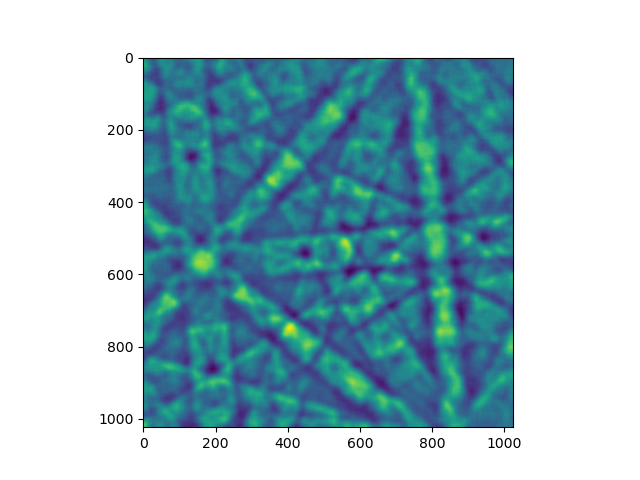

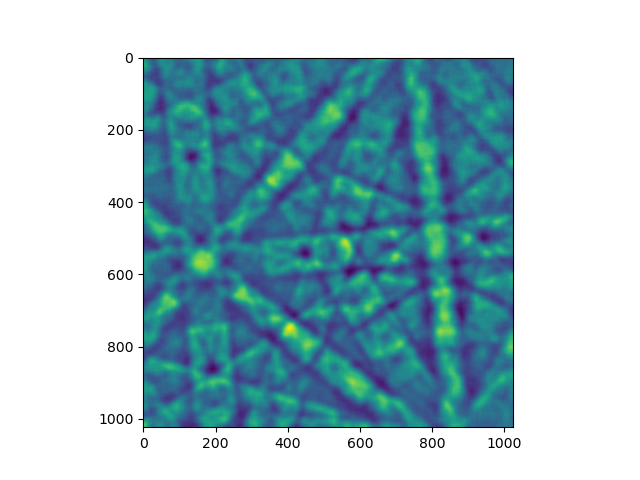

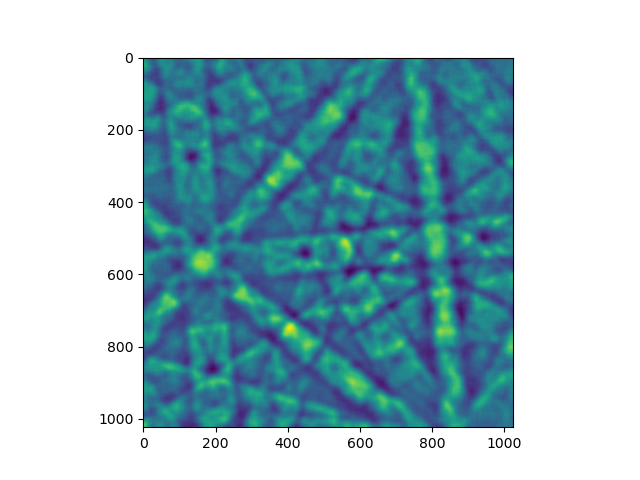

In [4]:
np.save(f"{name}_p.npy", p)
np.save(f"{name}_i_count.npy", i_count)
np.save(f"{name}_residuals.npy", residuals)

PC_mod = (ang_data.pc[0] - 512, ang_data.pc[1] - 512, PC[2])
Fe = pyHREBSD.homography_to_elastic_deformation(p, PC_mod)
# C = utilities.get_stiffness_tensor(165.6, 63.9, 79.5, structure="cubic")
# e, w, s = pyHREBSD.deformation_to_stress_strain(Fe, C, small_strain=False)
e, w = pyHREBSD.deformation_to_stress_strain(Fe, small_strain=False)

utilities.view_tensor_images(Fe, tensor_type="deformation", xy=(13, 13), save_name=name, save_dir="results/")
utilities.view_tensor_images(e, tensor_type="strain", xy=(13, 13), save_name=name, save_dir="results/", show="upper")
utilities.view_tensor_images(w, tensor_type="rotation", xy=(13, 13), save_name=name, save_dir="results/", show="upper")

